In [16]:
import cv2
import logging as log
import numpy as np
import queue
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import pandas as pd
import os

**Focus Method Comparison**

Comparing Laplacian and Normalized Variance algos for choosing in focus image across a variety of core samples. Will also be testing the viability of selecting regions of interest as proxy for whole image focus.

**NOTES**

Based on testing on a variety of images across a cookie sample, normalized variance scoring seems to be much more accurate when compared with laplacian scores.
This is in line with research on microscopy focus scoring (Yu Sun et al., Mir et al.).
'Best' images used for this comparison were chosen manually.  

In [31]:
dir = "./stack_test"
image_folders = os.listdir("./stack_test")

all_images= {}
best_images = {}
lap_best = {}
var_best = {}
images_df = pd.DataFrame(columns=['Name', 'Laplacian', 'NormalizedVariance'])
for folder in image_folders:
    image_filenames = os.listdir("{}/{}".format(dir, folder))
    arr_name = f"{folder}"
    all_images[arr_name] = []
    best_images[arr_name] = []
    lap_best[arr_name] = []
    var_best[arr_name] = []
    for image in image_filenames:
        if "best" in image:
            best_images[arr_name].append(image)
        all_images[arr_name].append(image)
        images_df = images_df.append({'Name': image}, ignore_index = True)

C:\Users\chloe\AppData\Local\Temp\ipykernel_27060\1832381623.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  images_df = images_df.append({'Name': image}, ignore_index = True)
C:\Users\chloe\AppData\Local\Temp\ipykernel_27060\1832381623.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  images_df = images_df.append({'Name': image}, ignore_index = True)
C:\Users\chloe\AppData\Local\Temp\ipykernel_27060\1832381623.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  images_df = images_df.append({'Name': image}, ignore_index = True)
C:\Users\chloe\AppData\Local\Temp\ipykernel_27060\1832381623.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

Functions for computing focus scores

In [154]:
def compute_laplacian(image):

    # odd numbers only, can be tuned
    kernel_size = 11         # Size of the laplacian window
    blur_size = 9           # How big of a kernel to use for the gaussian blur

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size) 

def best_focused_image_laplacian(folder, images):
    best_image = []
    best_lap = 0.0
    for image_name in images:
        image = cv2.imread("{}/{}/{}".format(dir, folder, image_name), cv2.IMREAD_GRAYSCALE)
        crop_image = image[0:2160, 0:2160]
        lap = compute_laplacian(crop_image)
        images_df.loc[images_df['Name'] == image_name, 'Laplacian'] = lap.var()
        print("Image: {}    Variance: {}".format(image_name, lap.var()))
        if lap.var() > best_lap:
            best_lap = lap.var()
            best_image = image_name
    return best_image

In [155]:
def compute_variance(image):
    # adapted from macro info at https://imagejdocu.list.lu/macro/normalized_variance
    mean = np.mean(image)
    width, height = image.shape
    square_diff = (image - mean)**2
    b = np.sum(square_diff)
    normVar = b/(height * width * mean)
    return normVar

def best_focused_image_variance(folder, images):
    best_image = []
    best_var = 0

    for image_name in images:
        image = cv2.imread("{}/{}/{}".format(dir, folder, image_name), cv2.IMREAD_GRAYSCALE)
        crop_image = image[0:2160, 0:2160]
        var = compute_variance(crop_image)
        images_df.loc[images_df['Name'] == image_name, 'NormalizedVariance'] = var
        print("Image: {}    Variance: {}".format(image_name, var))
        if var > best_var:
            best_image = image_name
            best_var = var

    return best_image

In [89]:
best_focused_image_variance('edge1', all_images['edge1'])

4.546030335552324
4.845444655468279
5.024152343906648
4.822713789522942
4.423067551061651
4.144609009715832
3.8740124210344455
3.6133365078908213
3.453431238974054
4.989730739928982


'edge1_2.tiff'

Compute focus scores for the entire image

In [90]:
for array in all_images:
    lap_best[array] = best_focused_image_laplacian(array, all_images[array])
    var_best[array] = best_focused_image_variance(array, all_images[array])

2.3465355337633564
2.4610817542580556
2.010108594821666
1.9352651320455032
2.5704975645688637
2.6767077668837147
2.6964622454229663
2.5966371113638766
2.4484776586592134
2.3204044600974854
2.1935590881974485
2.1026783289445596
2.73245480675966
4.450324337068335
4.607009982393186
4.3565153190115335
4.254281415694241
4.1475219126135
4.807631002239958
4.970768499281362
5.100028180047799
5.183561872677921
5.02219024856411
4.825107734057821
4.653000633322793
4.49943312123472
5.104679291337629
1.2031011132189613
1.1133082287454663
1.3010247848791305
1.4301475406474027
1.553802036568856
1.4033169388500242
1.2393250644250948
1.1158075130697012
1.0127151862489288
1.5218526317521317
1.0456747838989873
1.1081691847166228
1.1920623287295282
1.2886744634524343
1.3941597280111666
1.322047029356197
1.1764675776040423
1.0751021562122967
0.9786232555057534
1.4349254937872717
4.546030335552324
4.845444655468279
5.024152343906648
4.822713789522942
4.423067551061651
4.144609009715832
3.8740124210344455
3.

In [124]:
border1_df = images_df[:13]
border2_df = images_df[13:27]
center1_df = images_df[27:37]
center2_df = images_df[37:47]
edge1_df = images_df[47:57]
edge2_df = images_df[57:]

In [129]:
display(border1_df)
display(border2_df)
display(center1_df)
display(center2_df)
display(edge1_df)
display(edge2_df)


,Name,Laplacian,NormalizedVariance
0,border1_0.tiff,3346336734.357437,2.346536
1,border1_1.tiff,4632516109.089396,2.461082
2,border1_10.tiff,2853783477.834552,2.010109
3,border1_11.tiff,2682412989.66854,1.935265
4,border1_2.tiff,6353494096.109945,2.570498
5,border1_3.tiff,9615301443.335936,2.676708
6,border1_4.tiff,11749954865.466999,2.696462
7,border1_5.tiff,9920851152.582323,2.596637
8,border1_6.tiff,6799623747.503286,2.448478
9,border1_7.tiff,5073263962.451331,2.320404


,Name,Laplacian,NormalizedVariance
13,border2_0.tiff,3261389968.067848,4.450324
14,border2_1.tiff,3559276666.988393,4.60701
15,border2_10.tiff,3381694776.568821,4.356515
16,border2_11.tiff,3068292154.219989,4.254281
17,border2_12.tiff,2790398398.830302,4.147522
18,border2_2.tiff,4598565131.696301,4.807631
19,border2_3.tiff,6945543631.564677,4.970768
20,border2_4.tiff,9755853214.130465,5.100028
21,border2_5.tiff,14088855216.971436,5.183562
22,border2_6.tiff,12462007349.963993,5.02219


,Name,Laplacian,NormalizedVariance
27,center1_0.tiff,3861953458.403724,1.203101
28,center1_1.tiff,3389949483.19444,1.113308
29,center1_2.tiff,5041526811.815917,1.301025
30,center1_3.tiff,8536380297.970844,1.430148
31,center1_4.tiff,14426175041.25946,1.553802
32,center1_5.tiff,9863248559.94533,1.403317
33,center1_6.tiff,5685692274.498362,1.239325
34,center1_7.tiff,4155065614.089533,1.115808
35,center1_8.tiff,3476243830.522038,1.012715
36,center1_best.tiff,13761166330.351507,1.521853


,Name,Laplacian,NormalizedVariance
37,center2_0.tiff,3086216571.373142,1.045675
38,center2_1.tiff,3338092590.154811,1.108169
39,center2_2.tiff,4112710315.072697,1.192062
40,center2_3.tiff,6418667155.810447,1.288674
41,center2_4.tiff,10773071365.286417,1.39416
42,center2_5.tiff,9364105323.907736,1.322047
43,center2_6.tiff,5393330037.490623,1.176468
44,center2_7.tiff,3862218907.158511,1.075102
45,center2_8.tiff,3231002002.300162,0.978623
46,center2_best.tiff,13895767498.29285,1.434925


,Name,Laplacian,NormalizedVariance
47,edge1_0.tiff,12818952538.573153,4.54603
48,edge1_1.tiff,18507240786.992512,4.845445
49,edge1_2.tiff,24993146639.324188,5.024152
50,edge1_3.tiff,24386215477.285934,4.822714
51,edge1_4.tiff,14329688112.405546,4.423068
52,edge1_5.tiff,9170996983.158085,4.144609
53,edge1_6.tiff,6050615471.091779,3.874012
54,edge1_7.tiff,4492350181.168298,3.613337
55,edge1_8.tiff,3920684938.286204,3.453431
56,edge1_best.tiff,24826678866.278156,4.989731


,Name,Laplacian,NormalizedVariance
57,edge2_0.tiff,3570995368.656931,8.002343
58,edge2_1.tiff,3882458251.497239,8.184473
59,edge2_2.tiff,4397865626.787129,8.349915
60,edge2_3.tiff,5192685107.909925,8.500688
61,edge2_4.tiff,7213791638.253747,8.704603
62,edge2_5.tiff,12382952163.470724,8.954082
63,edge2_6.tiff,16768175314.190409,9.095943
64,edge2_7.tiff,15368495459.744629,8.938338
65,edge2_8.tiff,8967189971.872473,8.629388
66,edge2_9.tiff,5863994457.057392,8.391135


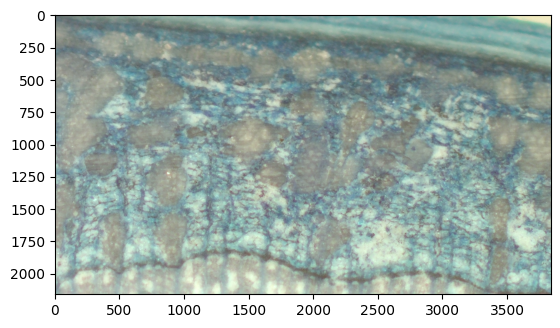

In [159]:
image = cv2.imread("./stack_test/edge1/edge1_best.tiff")
plt.imshow(image)

In [145]:
display(border1_df[border1_df['Name'] == 'border1_best.tiff'])
display(border1_df[border1_df['Laplacian'] == border1_df['Laplacian'].max()])
border1_df[border1_df['NormalizedVariance'] == border1_df['NormalizedVariance'].max()]

,Name,Laplacian,NormalizedVariance
12,border1_best.tiff,11469487512.150948,2.732455


,Name,Laplacian,NormalizedVariance
6,border1_4.tiff,11749954865.466999,2.696462


,Name,Laplacian,NormalizedVariance
12,border1_best.tiff,11469487512.150948,2.732455


In [140]:
display(border2_df[border2_df['Name'] == 'border2_best.tiff'])
display(border2_df[border2_df['Laplacian'] == border2_df['Laplacian'].max()])
border2_df[border2_df['NormalizedVariance'] == border2_df['NormalizedVariance'].max()]


,Name,Laplacian,NormalizedVariance
26,border2_best.tiff,12082361060.448164,5.104679


,Name,Laplacian,NormalizedVariance
21,border2_5.tiff,14088855216.971436,5.183562


,Name,Laplacian,NormalizedVariance
21,border2_5.tiff,14088855216.971436,5.183562


In [141]:
display(center1_df[center1_df['Name'] == 'center1_best.tiff'])
display(center1_df[center1_df['Laplacian'] == center1_df['Laplacian'].max()])
center1_df[center1_df['NormalizedVariance'] == center1_df['NormalizedVariance'].max()]

,Name,Laplacian,NormalizedVariance
36,center1_best.tiff,13761166330.351507,1.521853


,Name,Laplacian,NormalizedVariance
31,center1_4.tiff,14426175041.25946,1.553802


,Name,Laplacian,NormalizedVariance
31,center1_4.tiff,14426175041.25946,1.553802


In [142]:
display(center2_df[center2_df['Name'] == 'center2_best.tiff'])
display(center2_df[center2_df['Laplacian'] == center2_df['Laplacian'].max()])
center2_df[center2_df['NormalizedVariance'] == center2_df['NormalizedVariance'].max()]

,Name,Laplacian,NormalizedVariance
46,center2_best.tiff,13895767498.29285,1.434925


,Name,Laplacian,NormalizedVariance
46,center2_best.tiff,13895767498.29285,1.434925


,Name,Laplacian,NormalizedVariance
46,center2_best.tiff,13895767498.29285,1.434925


In [143]:
display(edge1_df[edge1_df['Name'] == 'edge1_best.tiff'])
display(edge1_df[edge1_df['Laplacian'] == edge1_df['Laplacian'].max()])
edge1_df[edge1_df['NormalizedVariance'] == edge1_df['NormalizedVariance'].max()]

,Name,Laplacian,NormalizedVariance
56,edge1_best.tiff,24826678866.278156,4.989731


,Name,Laplacian,NormalizedVariance
49,edge1_2.tiff,24993146639.324188,5.024152


,Name,Laplacian,NormalizedVariance
49,edge1_2.tiff,24993146639.324188,5.024152


In [153]:
display(edge2_df[edge2_df['Name'] == 'edge2_best.tiff'])
display(edge2_df[edge2_df['Laplacian'] == edge2_df['Laplacian'].max()])
edge2_df[edge2_df['NormalizedVariance'] == edge2_df['NormalizedVariance'].max()]

,Name,Laplacian,NormalizedVariance
67,edge2_best.tiff,21751942224.016804,9.159198


,Name,Laplacian,NormalizedVariance
67,edge2_best.tiff,21751942224.016804,9.159198


,Name,Laplacian,NormalizedVariance
67,edge2_best.tiff,21751942224.016804,9.159198


In [156]:
best_focused_image_laplacian('edge2', all_images['edge2'])
best_focused_image_variance('edge2', all_images['edge2'])

Image: edge2_0.tiff    Variance: 3351842775.8597364
Image: edge2_1.tiff    Variance: 3562144909.607546
Image: edge2_2.tiff    Variance: 3928635613.89633
Image: edge2_3.tiff    Variance: 4566673569.741827
Image: edge2_4.tiff    Variance: 6047361736.916189
Image: edge2_5.tiff    Variance: 8360173462.079832
Image: edge2_6.tiff    Variance: 7934316331.08275
Image: edge2_7.tiff    Variance: 4543447874.538392
Image: edge2_8.tiff    Variance: 3484287946.3144264
Image: edge2_9.tiff    Variance: 3110953321.4523335
Image: edge2_best.tiff    Variance: 6996453656.061086
Image: edge2_0.tiff    Variance: 7.287056493840229
Image: edge2_1.tiff    Variance: 7.023861219265056
Image: edge2_2.tiff    Variance: 6.9957074533259505
Image: edge2_3.tiff    Variance: 6.990290747356876
Image: edge2_4.tiff    Variance: 7.0282440665853665
Image: edge2_5.tiff    Variance: 7.0429430081183195
Image: edge2_6.tiff    Variance: 6.990212088598614
Image: edge2_7.tiff    Variance: 6.718503878098697
Image: edge2_8.tiff    V

'edge2_0.tiff'

(2160, 3840, 3)


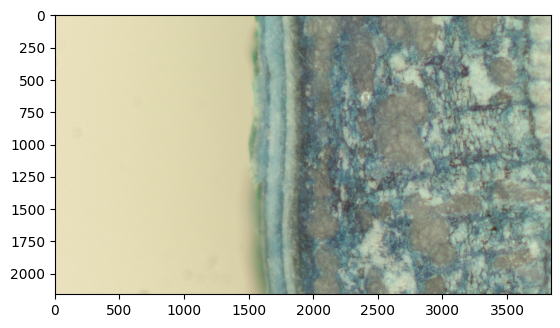

In [161]:
image = cv2.imread("./stack_test/edge2/edge2_best.tiff")
print(image.shape)
display(plt.imshow(image))

(2160, 3840, 3)


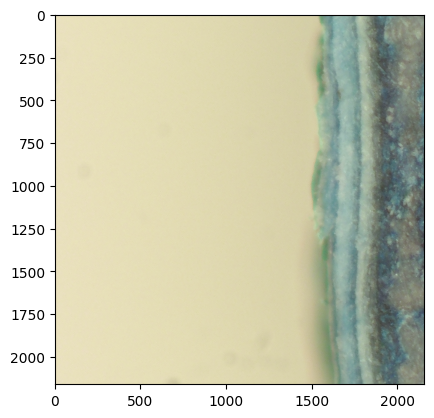

In [160]:
image = cv2.imread("./stack_test/edge2/edge2_best.tiff")
print(image.shape)
display(plt.imshow(image))
crop_image = image[0:2160, 0:2160]
plt.imshow(crop_image)


In [106]:
for arr in lap_best:
    print(str(lap_best[arr]) == str(best_images[arr][0]))

False
False
False
True
False
True


In [99]:
for arr in var_best:
    print(str(var_best[arr]) == str(best_images[arr][0]))

True
False
False
True
False
True
